In [1]:
# Import to shut down the warning about tensorflow compilation with avx
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# util routines to prepare and plot the data
from utils import *

## Load and prepare data
We load, and then split in train, validation, test set

In [2]:
BH_tcs = load_data("data/{}.csv".format('BH_tcs_1e6'))
train_data, train_targets, val_data, val_targets, test_data, test_targets = prepare_data(BH_tcs)

Train / Val / Test set: 700000 / 150000 / 150000


## Model Build

__1)__ Define a function to build a keras model

In [3]:
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model():
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 2))
    model.add (layers.Dense(64, activation="relu"))
    model.add (layers.Dense(64, activation="relu"))
    model.add (layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=["mae","binary_crossentropy"])
    return model

__2)__ Fit the model and save it

In [4]:
# Build, fit model
model = build_model()
history = model.fit(train_data, train_targets,
                    epochs = 100,
                    batch_size = 4000,
                    validation_data = (val_data, val_targets),
                    verbose=0,
                    )
model.save("models/{}.h5".format('BH_tcs_pred'))

## Metrics: mae, mse and bce
__1)__ Evaluate and compute metrics

In [5]:
train_mse, train_mae, train_bce = model.evaluate(train_data, train_targets, verbose=0)
val_mse, val_mae, val_bce = model.evaluate(val_data, val_targets, verbose=0)
test_mse, test_mae, test_bce = model.evaluate(test_data, test_targets, verbose=0)

__2)__ Show the metrics to check overfitting

In [6]:
print('Train / Val / Test')
print('mse = {:.2e}, {:.2e}, {:.2e}'.format(train_mse, val_mse, test_mse))
print('mae = {:.2e}, {:.2e}, {:.2e}'.format(train_mae, val_mae, test_mae))
print('bce = {:.2e}, {:.2e}, {:.2e}'.format(train_bce, val_bce, test_bce))

Train / Val / Test
mse = 4.71e-04, 4.68e-04, 4.70e-04
mae = 1.18e-02, 1.17e-02, 1.18e-02
bce = 6.02e-01, 6.02e-01, 6.02e-01


## Prediction on test set
__1)__ Predict the target of the test set

In [7]:
# Predict from the test_data
test_pred = model.predict(test_data)
test_pred = test_pred.reshape(test_pred.shape[0])

4688/4688 [==============================] - 3s 631us/step


__2)__ Plot the result

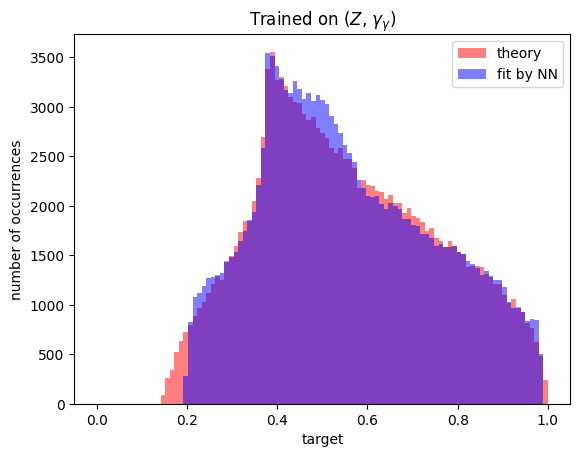

In [10]:
import matplotlib.pyplot as plt

bins = np.linspace(0., 1., 100)

plt.hist(test_targets, bins, color = 'r', alpha=0.5, label='theory')
plt.hist(test_pred, bins, color = 'b', alpha=0.5, label='fit by NN')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('target')
plt.ylabel('number of occurrences')
plt.title('Trained on ($Z$, $\gamma_{\gamma}$)')
plt.show()

__3)__ Plot the learning curve

/Users/bertrand/Documents/studies/qed_q3d/bh_ML/utils.py:139: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


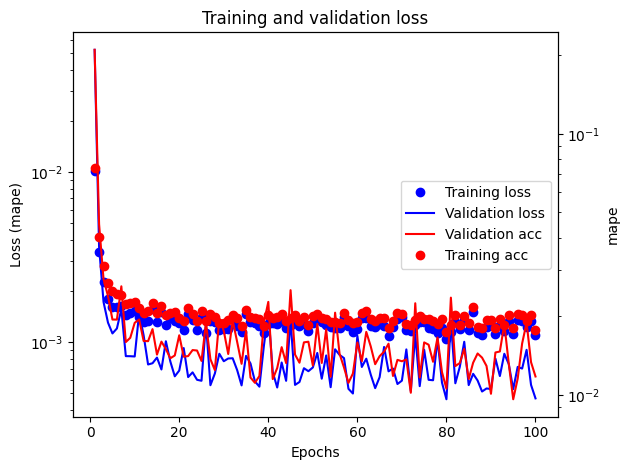

In [9]:
plot_history(history)